# Deep Learning
## Assignment 1 - Beat the market
### Abel de Wit & Malin Hjärtström


In [1]:
# Getting the data (commented for local use)
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
import tensorflow as tf
print(tf.__version__)

2.0.0


In [41]:
import pandas as pd
from keras.models import Sequential
from keras.optimizers import RMSprop
pd.set_option('mode.chained_assignment', None)

In [42]:
info_data = pd.read_csv("data/info.txt", sep='\s+')
market_analysis = pd.read_csv("data/market_analysis.txt", sep='\s+')

market_segments = pd.read_csv("data/market_segments.txt", sep='\s+')
stock_prices = pd.read_csv("data/stock_prices.txt", sep='\s+')

# Do something with all our data so we can feed it to the NN
dataframe = info_data
dataframe["stock-price"] = stock_prices['stock-price']

# 'One hot encoding' the segments
dataframe["IT"] = dataframe['company'].apply(lambda x: 0 if x == 1 else 1)
dataframe["BIO"] = dataframe['company'].apply(lambda x: 1 if x == 1 else 0)

# Setting the indexes as the date
dataframe.set_index(['year', 'day'], inplace=True)


# For now we dont use some data
# del dataframe['sentiment']
# del dataframe['m1']
# del dataframe['m2']
# del dataframe['m3']
# del dataframe['m4']

dataframe


company  quarter  expert1  expert2  sentiment   m1    m2   m3  m4  \
year day                                                                      
2017 3          0        0        0        0         10  6.3  1824 -1.0   0   
     4          0        0        0        1         10  5.1  6912 -0.9   0   
     5          0        0        0        1         10  6.6  8928  0.3   0   
     6          0        0        0        1         10  7.8  6924  0.0   0   
     9          0        0        0        1         10 -0.9  5635  0.9   0   
...           ...      ...      ...      ...        ...  ...   ...  ...  ..   
2019 175        2        1        0        0          1 -1.9  4031 -0.1   0   
     176        2        1        0        0          1  7.0  2243 -0.2   0   
     177        2        1        0        0          2  3.5  5960 -0.8   0   
     178        2        1        0        0          1 -5.3  1524 -0.6   0   
     179        2        1        0        0          1 -1.5  5215 -0.7   0   

          stock-price  IT  BIO  
year day                        
2017 3          102.2   1    0  
     4          102.2   1    0  
     5          102.2   1    0  
     6          102.2   1    0  
     9          102.2   1    0  
...               ...  ..  ...  
2019 175         13.0   1    0  
     176         10.5   1    0  
     177         10.4   1    0  
     178         10.7   1    0  
     179         11.5   1    0  

[1878 rows x 12 columns]

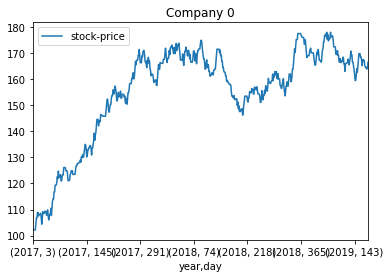

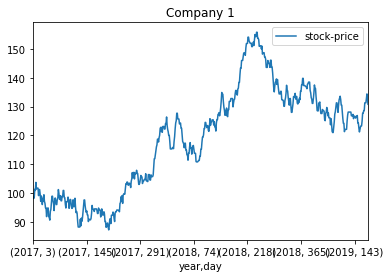

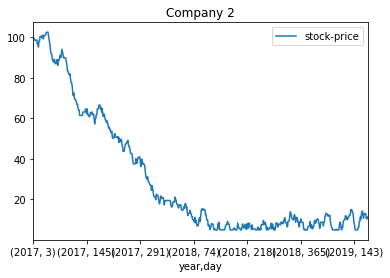

In [43]:
# Now we split into companies

company_0 = dataframe[dataframe['company'] == 0]
company_1 = dataframe[dataframe['company'] == 1]
company_2 = dataframe[dataframe['company'] == 2]

# Let's see how their stocks are doing

company_0.plot(y='stock-price').set_title('Company 0')
company_1.plot(y='stock-price').set_title('Company 1')
company_2.plot(y='stock-price').set_title('Company 2')

del company_0['company']
del company_0['quarter']
del company_1['company']
del company_1['quarter']
del company_2['company']
del company_2['quarter']

We want to predict wether the stock goes up or not, so we have to change the stock price values in such a way that it is binary.

`if stock-price-today - stock-price-yesterday > 0 then 1, else 0`

In [44]:
import numpy as np

company_0['stock-price-binary'] = np.where(company_0['stock-price'] > company_0['stock-price'].shift(), 1, 0)
del company_0['stock-price']

company_1['stock-price-binary'] = np.where(company_1['stock-price'] > company_1['stock-price'].shift(), 1, 0)
del company_1['stock-price']

company_2['stock-price-binary'] = np.where(company_2['stock-price'] > company_2['stock-price'].shift(), 1, 0)
del company_2['stock-price']


company_0

expert1  expert2  sentiment   m1    m2   m3  m4  IT  BIO  \
year day                                                             
2017 3          0        0         10  6.3  1824 -1.0   0   1    0   
     4          0        1         10  5.1  6912 -0.9   0   1    0   
     5          0        1         10  6.6  8928  0.3   0   1    0   
     6          0        1         10  7.8  6924  0.0   0   1    0   
     9          0        1         10 -0.9  5635  0.9   0   1    0   
...           ...      ...        ...  ...   ...  ...  ..  ..  ...   
2019 175        1        0          4  7.8  4444 -0.9   0   1    0   
     176        0        0          5  6.8  5901 -0.7   0   1    0   
     177        0        0          4  8.1  1631  0.0   0   1    0   
     178        0        0          5  4.3   352 -0.9   0   1    0   
     179        0        1          5 -1.2  5765  0.1   0   1    0   

          stock-price-binary  
year day                      
2017 3                     0  
     4                     0  
     5                     0  
     6                     0  
     9                     0  
...                      ...  
2019 175                   0  
     176                   0  
     177                   0  
     178                   0  
     179                   1  

[626 rows x 10 columns]

# Model definition

So now we have the data in a nice table, split into seperate companies, we can do some machine learning!

In [45]:
# Scale data
from sklearn.preprocessing import MinMaxScaler
import datetime, os
from keras.callbacks import TensorBoard
from keras.layers import Dense, Dropout, LSTM
from keras import regularizers
from sklearn.externals import joblib

def train_company(company, name):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(company)
    scaled = pd.DataFrame(data=scaled, columns=company.columns)
    
    scaler_filename = "models/scaler " + name + ".save"
    joblib.dump(scaler, scaler_filename) 

    X = scaled.loc[:, scaled.columns != 'stock-price-binary']
    y = scaled['stock-price-binary']
    
    num_features = X.shape[1]

    # Now we split the data
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
    
    # Create a model.
    model = Sequential()
    model.add(Dense(64, input_dim=num_features, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, input_dim=num_features, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    #model.summary()

    # Tensorboard stuff
    log_dir = os.path.join(
        "logs",
        name,
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(log_dir, histogram_freq=1)

    # Train the model
    model.fit(x=X_train, 
              y=y_train, 
              epochs=100,
              batch_size = 50,
              shuffle=False,
              validation_data=(X_val, y_val),
              callbacks=[tensorboard_callback],
              verbose=0)
    return model, X_test, y_test

In [46]:
companies = [company_0, company_1, company_2]

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

models = []
i = 0

for company in companies:
    model_company, X_test, y_test = train_company(company, "Company " + str(i))
    i += 1
    models.append(model_company)
    y_pred = model_company.predict_classes(X_test)
    y_pred = y_pred[:, 0]
    
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, y_pred)
    print("-"*20)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, y_pred)
    print('F1 score: %f' % f1)
    print("-"*20)
    model_company.save('models/c' + str(i) + '.h5')
    

--------------------
Accuracy: 0.841270
Precision: 0.764706
Recall: 0.684211
F1 score: 0.722222
--------------------
--------------------
Accuracy: 0.777778
Precision: 0.739130
Recall: 0.680000
F1 score: 0.708333
--------------------
--------------------
Accuracy: 0.746032
Precision: 0.714286
Recall: 0.454545
F1 score: 0.555556
--------------------


# Combination of all 3

In [8]:
stock_prices = pd.DataFrame()

stock_prices['spb_0'] = company_0['stock-price-binary']
del company_0['stock-price-binary']

stock_prices['spb_1'] = company_1['stock-price-binary']
del company_1['stock-price-binary']

stock_prices['spb_2'] = company_2['stock-price-binary']
del company_2['stock-price-binary']

big_dataframe = pd.concat([company_0, company_1], axis=1) 
big_dataframe = pd.concat([big_dataframe, company_2], axis=1) 
big_dataframe = pd.concat([big_dataframe, stock_prices], axis=1)

In [9]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(big_dataframe)
scaled = pd.DataFrame(data=scaled, columns=big_dataframe.columns)

scaler_filename = "models/scaler Company 13.save"
joblib.dump(scaler, scaler_filename) 

X = scaled.iloc[:, :-3]
y = scaled.iloc[:, -3:]

# Now we split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

num_features = X.shape[1]

# Create a model.
model = Sequential()
model.add(Dense(128, input_dim=num_features, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#model.summary()

# Tensorboard stuff
log_dir = os.path.join(
    "logs",
    "Company 1-3",
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir, histogram_freq=1)

# Train the model
model.fit(x=X_train, 
          y=y_train, 
          epochs=100,
          batch_size = 50,
          shuffle=False,
          validation_data=(X_val, y_val),
          callbacks=[tensorboard_callback],
          verbose=1)

model.save('models/c13.h5')

Train on 450 samples, validate on 113 samples
Epoch 1/100
450/450 [==============================] - 0s 548us/step - loss: 0.6984 - accuracy: 0.5185 - val_loss: 0.6665 - val_accuracy: 0.7021
Epoch 2/100
450/450 [==============================] - 0s 38us/step - loss: 0.6496 - accuracy: 0.6696 - val_loss: 0.6332 - val_accuracy: 0.6726
Epoch 3/100
450/450 [==============================] - 0s 36us/step - loss: 0.6183 - accuracy: 0.6622 - val_loss: 0.6095 - val_accuracy: 0.6755
Epoch 4/100
450/450 [==============================] - 0s 33us/step - loss: 0.6001 - accuracy: 0.6681 - val_loss: 0.5877 - val_accuracy: 0.6844
Epoch 5/100
450/450 [==============================] - 0s 33us/step - loss: 0.5753 - accuracy: 0.6874 - val_loss: 0.5573 - val_accuracy: 0.7345
Epoch 6/100
450/450 [==============================] - 0s 39us/step - loss: 0.5457 - accuracy: 0.7393 - val_loss: 0.5240 - val_accuracy: 0.7640
Epoch 7/100
450/450 [==============================] - 0s 37us/step - loss: 0.5160 - accu

450/450 [==============================] - 0s 37us/step - loss: 0.1979 - accuracy: 0.9133 - val_loss: 0.3611 - val_accuracy: 0.8496
Epoch 58/100
450/450 [==============================] - 0s 40us/step - loss: 0.2071 - accuracy: 0.9059 - val_loss: 0.3617 - val_accuracy: 0.8437
Epoch 59/100
450/450 [==============================] - 0s 36us/step - loss: 0.2001 - accuracy: 0.9148 - val_loss: 0.3608 - val_accuracy: 0.8496
Epoch 60/100
450/450 [==============================] - 0s 41us/step - loss: 0.2016 - accuracy: 0.9170 - val_loss: 0.3719 - val_accuracy: 0.8407
Epoch 61/100
450/450 [==============================] - 0s 38us/step - loss: 0.1926 - accuracy: 0.9207 - val_loss: 0.3746 - val_accuracy: 0.8496
Epoch 62/100
450/450 [==============================] - 0s 35us/step - loss: 0.1870 - accuracy: 0.9252 - val_loss: 0.3797 - val_accuracy: 0.8466
Epoch 63/100
450/450 [==============================] - 0s 31us/step - loss: 0.1883 - accuracy: 0.9267 - val_loss: 0.3706 - val_accuracy: 0.846

In [10]:
y_pred = model.predict(X_test)
print(X_test)

for r in range( y_pred.shape[0] ):
    for c in range( y_pred.shape[1] ):
        if y_pred[r,c] > 0.5:
            y_pred[r,c] = 1
        else:
            y_pred[r,c] = 0
    
print(y_pred)

     expert1  expert2  sentiment     m1        m2    m3   m4   IT  BIO  \
563      0.0      1.0   0.571429  0.400  0.519430  1.00  0.0  0.0  0.0   
564      0.0      0.0   0.571429  0.460  0.963751  0.80  0.0  0.0  0.0   
565      0.0      0.0   0.571429  0.845  0.412090  0.10  0.0  0.0  0.0   
566      1.0      0.0   0.571429  0.065  0.041470  0.60  0.0  0.0  0.0   
567      0.0      1.0   0.571429  0.495  0.507079  0.35  0.0  0.0  0.0   
..       ...      ...        ...    ...       ...   ...  ...  ...  ...   
621      1.0      0.0   0.142857  0.890  0.444422  0.05  0.0  0.0  0.0   
622      0.0      0.0   0.285714  0.840  0.590722  0.15  0.0  0.0  0.0   
623      0.0      0.0   0.142857  0.905  0.161964  0.50  0.0  0.0  0.0   
624      0.0      0.0   0.285714  0.715  0.033538  0.05  0.0  0.0  0.0   
625      0.0      1.0   0.285714  0.440  0.577066  0.55  0.0  0.0  0.0   

     expert1  ...  BIO  expert1  expert2  sentiment     m1        m2    m3  \
563      1.0  ...  0.0      0.0  